# Programming Exercise 6: Support Vector Machines

> In this exercise, you will be using support vector machines (SVMs) to build a spam classifier.

## 1. Support Vector Machines

### 1.1 Example Dataset 1

> We will begin by with a 2D example dataset which can be separated by a linear boundary.

In [185]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [186]:
mat = scipy.io.loadmat('data/ex6data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

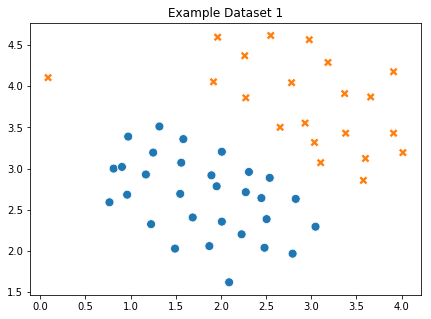

In [187]:
plt.figure(figsize=(7,5))
ax = sns.scatterplot(x=mat['X'][:,0], y=mat['X'][:,1], hue=mat['y'].ravel(), style=mat['y'].ravel(), s=80, legend=False)
plt.title('Example Dataset 1')
plt.show(ax)

#### Decision Boundary

In [188]:
def plot_boundary(X, y, model, title):
    ax = sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, s=80, legend=False)
    ax.set(title=title)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    Z = model.decision_function(xy).reshape(XX.shape)
    a = ax.contour(XX, YY, Z, colors='g', levels=[0], linestyles=['--'])

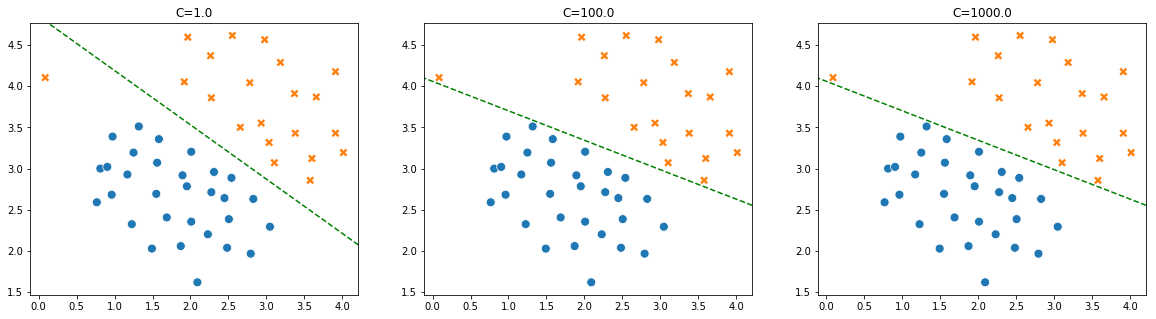

In [189]:
from sklearn import svm

c_vals = [1.0, 100.0, 1000.0]
plt.figure(figsize=(20,5))

for i, c in enumerate(c_vals):
    clf = svm.SVC(kernel='linear', C=c)
    clf.fit(mat['X'], mat['y'].ravel())
    
    plt.subplot(1,3,i+1)
    plot_boundary(mat['X'], mat['y'].ravel(), clf, 'C={}'.format(c))
    
plt.show()

### 1.2 SVM with Gaussian Kernels

Gaussian kernel:

$$ K_{gaussian}(x^{(i)}, x^{(j)}) = exp\bigg(-\frac{||x^{(i)}-x^{(j)} ||^2 }{2\sigma^2}\bigg) = exp\Bigg(-\frac{\sum_{k=1}^n(x_k^{(i)}-x_k^{(j)})^2}{2\sigma^2}\Bigg)$$

In [190]:
def gaussian_kernel(x1, x2, sigma=0.1):
    x1 = x1.ravel()
    x2 = x2.ravel()
    sumx1x2 = np.sum((x1-x2)**2)
    return np.exp(-sumx1x2/(2*sigma**2))

In [191]:
x1 = np.array([1,2,1])
x2 = np.array([0,4,-1])
sigma = 2
gk = gaussian_kernel(x1, x2, sigma)
print('Gaussian Kernel between x1 = [1; 2; 1], x2 = [0; 4; -1], sigma = {0} : {1}\n\t(for sigma = 2, this value should be about 0.324652)\n'.format(sigma, gk))

Gaussian Kernel between x1 = [1; 2; 1], x2 = [0; 4; -1], sigma = 2 : 0.32465246735834974
	(for sigma = 2, this value should be about 0.324652)



#### 1.2.2 Example Dataset 2

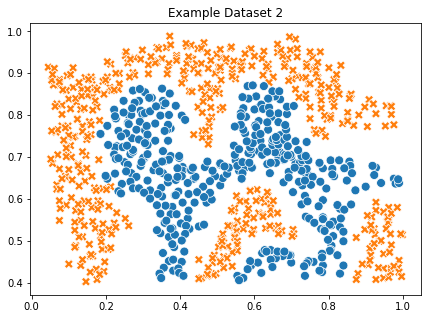

In [192]:
mat = scipy.io.loadmat('data/ex6data2.mat')
plt.figure(figsize=(7,5))
ax = sns.scatterplot(x=mat['X'][:,0], y=mat['X'][:,1], hue=mat['y'].ravel(), style=mat['y'].ravel(), s=80, legend=False)
plt.title('Example Dataset 2')
plt.show(ax)

In [193]:
def gaussian_kernel_matrix(X1, X2, sigma=0.1):
    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            gram_matrix[i, j] = gaussian_kernel(x1, x2, sigma)
    return gram_matrix

In [194]:
def plot_gaussian_boundary(X, y, model, title='SVM Decision Boundary for Gaussian Kernel'):
    plt.figure(figsize=(7,5))
    ax = sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, s=80, legend=False)
    ax.set(title=title)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    gram = gaussian_kernel_matrix(xy, X)
    Z = model.predict(gram).reshape(XX.shape)

    a = ax.contour(XX, YY, Z, colors='g', levels=[0.5], linestyles=['--'])
    plt.show()

In [195]:
clf = svm.SVC(kernel="precomputed", C=1.0, verbose=True)
gram = gaussian_kernel_matrix(mat['X'], mat['X'], sigma=0.1)
clf.fit(gram, mat['y'].ravel())

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='precomputed', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=True)

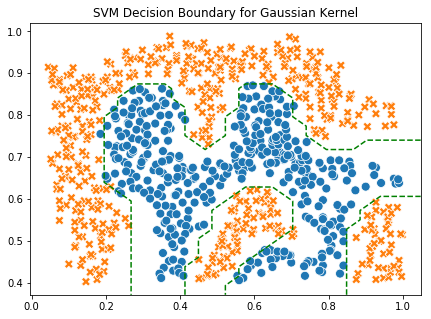

In [196]:
plot_gaussian_boundary(mat['X'], mat['y'].ravel(), clf)

#### 1.2.3 Example Dataset 3

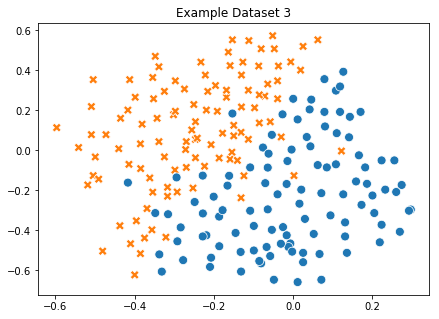

In [197]:
mat = scipy.io.loadmat('data/ex6data3.mat')
plt.figure(figsize=(7,5))
ax = sns.scatterplot(x=mat['X'][:,0], y=mat['X'][:,1], hue=mat['y'].ravel(), style=mat['y'].ravel(), s=80, legend=False)
plt.title('Example Dataset 3')
plt.show(ax)

#### Best parameters $C$ and $\sigma$

In [198]:
def find_best_c_sigma(X, y, Xval, yval):

    C_vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    sigma_vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    error = 9999

    C = 0.01
    sigma = 0.01
    for c in C_vals:
        for s in sigma_vals:
            clf = svm.SVC(kernel="precomputed", C=c)
            gram = gaussian_kernel_matrix(X, X, sigma=s)
            clf.fit(gram, y)

            gram_pred = gaussian_kernel_matrix(Xval, X)
            y_pred = clf.predict(gram_pred)
            
            error_mean = np.mean(y_pred != yval)
            if error_mean < error:
                C = c
                sigma = s
                error = error_mean
    return C, sigma

In [199]:
C, sigma = find_best_c_sigma(mat['X'], mat['y'].ravel(), mat['Xval'], mat['yval'].ravel())

In [200]:
clf = svm.SVC(kernel="precomputed", C=C)
gram = gaussian_kernel_matrix(mat['X'], mat['X'], sigma=sigma)
clf.fit(gram, mat['y'].ravel())

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='precomputed', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

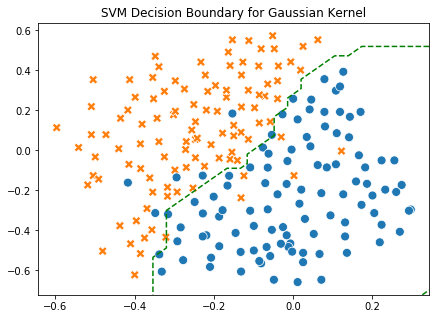

In [201]:
plot_gaussian_boundary(mat['X'], mat['y'].ravel(), clf)

## 2. Spam Classification

> Many email services today provide spam filters that are able to classify emails into spam and non-spam email with high accuracy. In this part of the exercise, you will use SVMs to build your own spam filter.
You will be training a classifier to classify whether a given email, x, is spam (y = 1) or non-spam (y = 0). 

### 2.1 Preprocessing Emails

In [421]:
f = open('data/emailSample1.txt', 'r')
contents = f.read()
print(contents)

> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




#### Preprocessing steps:

* Lower case
* Strip all HTML: Looks for any expression that starts with < and ends with > and replace with a space
* Handle numbers: Replace numbers with the text 'number'
* Handle URLS: Replace URLs with the text 'httpaddr'
* Handle Email Addresses: Replace email addresses with the text 'emailaddr'
* Handle Dollars $: Replace \$ with the text 'dollar'
* Remove non-words: Remove non alphanumeric characters and punctuation
* Word stemming

In [430]:
import re
import string
from nltk.stem import PorterStemmer

def process_email(email_contents):
    processed = email_contents.lower()
    processed = re.sub('<[^<>]+>', ' ', processed)
    processed = re.sub('[0-9]+', 'number', processed)
    processed = re.sub('(http|https)://[^\s]*', 'httpaddr', processed)
    processed = re.sub('[^\s]+@[^\s]+', 'emailaddr', processed)
    processed = re.sub('[$]+', 'dollar', processed)
    
    for punctuation in string.punctuation:
        processed = processed.replace(punctuation, ' ')
        
    stemmer = PorterStemmer()
    processed = ' '.join([stemmer.stem(re.sub('[^a-zA-Z0-9]', '', word)) for word in processed.split()])
    processed = ' '.join(processed.split())    
    return processed.strip()

In [431]:
process_email(contents)

'anyon know how much it cost to host a web portal well it depend on how mani visitor you re expect thi can be anywher from less than number buck a month to a coupl of dollarnumb you should checkout httpaddr or perhap amazon ecnumb if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr'

#### 2.1.1 Vocabulary List

In [432]:
df_vocab = pd.read_csv('data/vocab.txt', sep='\t', header=None)
df_vocab.columns = ['index', 'word']
df_vocab.sample(5)

,index,word
505,506,easi
223,224,busi
548,549,ensur
1749,1750,unit
1771,1772,useless


In [433]:
def process_email_and_get_indices(text):
    text = process_email(text)
    print('\n======= Processed Email =======\n', text, '\n========\n')
    df_vocab = pd.read_csv('data/vocab.txt', sep='\t', header=None)
    df_vocab.columns = ['index', 'word']
    indices = [df_vocab[df_vocab.word==word]['index'].values[0] for word in text.split() if len(df_vocab[df_vocab.word==word]['index'].values > 0)]
    return indices

In [434]:
word_indices = process_email_and_get_indices(contents)
print(word_indices)


======= Processed Email =======
 anyon know how much it cost to host a web portal well it depend on how mani visitor you re expect thi can be anywher from less than number buck a month to a coupl of dollarnumb you should checkout httpaddr or perhap amazon ecnumb if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr 

[86, 916, 794, 1077, 883, 370, 1699, 790, 1822, 1831, 883, 431, 1171, 794, 1002, 1893, 1364, 592, 1676, 238, 162, 89, 688, 945, 1663, 1120, 1062, 1699, 375, 1162, 479, 1893, 1510, 799, 1182, 1237, 810, 1895, 1440, 1547, 181, 1699, 1758, 1896, 688, 1676, 992, 961, 1477, 71, 530, 1699, 531]


### 2.2 Extracting Features from Emails

In [435]:
def email_features(indices):
    n = 1899
    x = np.zeros((n,1))
    x[indices]=1
    return x

In [436]:
features = email_features(word_indices)

In [437]:
print('Length of feature vector:', len(features))
print('Number of non-zero entries:', sum(features==1)[0])

Length of feature vector: 1899
Number of non-zero entries: 45


### 2.3 Training SVM for Spam Classification

In [438]:
data = scipy.io.loadmat('data/spamTrain.mat')
data_test = scipy.io.loadmat('data/spamTest.mat')

In [439]:
clf = svm.SVC(kernel='linear', C=0.1)
clf.fit(data['X'], data['y'].ravel())

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [440]:
print('Training Accuracy:', clf.score(data['X'], data['y'].ravel()))

Training Accuracy: 0.99825


In [441]:
print('Test Accuracy:', clf.score(data_test['Xtest'], data_test['ytest'].ravel()))

Test Accuracy: 0.989


### 2.4 Top Predictors for Spam

In [442]:
df_vocab['weights'] = clf.coef_[0,:]

In [443]:
df_vocab.sort_values(by='weights', ascending=False).head(15)

,index,word,weights
1190,1191,our,0.500614
297,298,click,0.465916
1397,1398,remov,0.422869
738,739,guarante,0.383622
1795,1796,visit,0.367710
155,156,basenumb,0.345064
476,477,dollar,0.323632
1851,1852,will,0.269724
1298,1299,price,0.267298
1263,1264,pleas,0.261169


### Predicting on new email

In [444]:
f = open('data/spamSample1.txt', 'r')
contents = f.read()
word_indices = process_email_and_get_indices(contents)
x = email_features(word_indices)
y_pred = clf.predict(x.reshape(1,-1))
print('Spam Classification:', y_pred[0])


======= Processed Email =======
 do you want to make dollarnumb or more per week if you are a motiv and qualifi individu i will person demonstr to you a system that will make you dollarnumb number per week or more thi is not mlm call our number hour pre record number to get the detail number number number i need peopl who want to make seriou money make the call and get the fact invest number minut in yourself now number number number look forward to your call and i will introduc you to peopl like yourself who are current make dollarnumb number plu per week number number number numberljgvnumb numberleannumberlrmsnumb numberwxhonumberqiytnumb numberrjuvnumberhqcfnumb numbereidbnumberdmtvlnumb 

Spam Classification: 0


In [445]:
f = open('data/spamSample2.txt', 'r')
contents = f.read()
word_indices = process_email_and_get_indices(contents)
x = email_features(word_indices)
y_pred = clf.predict(x.reshape(1,-1))
print('Spam Classification:', y_pred[0])


======= Processed Email =======
 best buy viagra gener onlin viagra numbermg x number pill dollarnumb free pill reorder discount top sell number qualiti satisfact guarante we accept visa master e check payment number satisfi custom httpaddr 

Spam Classification: 1


In [446]:
f = open('data/emailSample1.txt', 'r')
contents = f.read()
word_indices = process_email_and_get_indices(contents)
x = email_features(word_indices)
y_pred = clf.predict(x.reshape(1,-1))
print('Spam Classification:', y_pred[0])


======= Processed Email =======
 anyon know how much it cost to host a web portal well it depend on how mani visitor you re expect thi can be anywher from less than number buck a month to a coupl of dollarnumb you should checkout httpaddr or perhap amazon ecnumb if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr 

Spam Classification: 0


In [447]:
f = open('data/emailSample2.txt', 'r')
contents = f.read()
word_indices = process_email_and_get_indices(contents)
x = email_features(word_indices)
y_pred = clf.predict(x.reshape(1,-1))
print('Spam Classification:', y_pred[0])


======= Processed Email =======
 folk my first time post have a bit of unix experi but am new to linux just got a new pc at home dell box with window xp ad a second hard disk for linux partit the disk and have instal suse number number from cd which went fine except it didn t pick up my monitor i have a dell brand enumberfpp number lcd flat panel monitor and a nvidia geforcenumb tinumb video card both of which are probabl too new to featur in suse s default set i download a driver from the nvidia websit and instal it use rpm then i ran saxnumb as wa recommend in some post i found on the net but it still doesn t featur my video card in the avail list what next anoth problem i have a dell brand keyboard and if i hit cap lock twice the whole machin crash in linux not window even the on off switch is inact leav me to reach for the power cabl instead if anyon can help me in ani way with these prob i d be realli grate i ve search the net but have run out of idea or should i be go for a diff